# Sistema de Recomendación para películas

## Factorización SGD

### Carga de Librerías (Python 3.7)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from numpy.linalg import svd
from numpy.linalg import linalg
from time import time
import random

### Importar archivo con calificaciones (ratings)

In [2]:
# Conjunto de datos con un cien mil de calificaciones (cifra redondeada)
ratings = pd.read_csv(r'ratings.csv')

### Mapeo de Usuarios y de Películas

In [3]:
# El mapeo lo que hace es tener un id consecutivo y único de usuarios y de películas
# La tabla original de películas no tiene id consecutivos

lista_pelic = ratings['movieId'].unique()
num_pelic = len(lista_pelic)
mapeo_pelic = {}
for n, m in enumerate(lista_pelic):
    mapeo_pelic[m] = n
lista_usuarios = ratings['userId'].unique()
num_usuarios = len(lista_usuarios)
mapeo_usuarios = {}
for n, m in enumerate(lista_usuarios):
    mapeo_usuarios[m] = n

### Creación de Matriz de usuarios y películas

In [4]:
matriz_uspl = np.zeros([num_usuarios, num_pelic])
for index, row in ratings.iterrows():
    matriz_uspl[mapeo_usuarios[row['userId']], mapeo_pelic[row['movieId']]] = int(row['rating'])

# Se guarda una copia como Data Frame
matriz_df = pd.DataFrame(matriz_uspl)    

#### Función para cálculo de Raíz del Error Cuadrático Medio (RMSE)

In [6]:
# Raíz del Error Cuadrático Medio (RMSE)
def RSME(pred,original):
    N = pred.shape[0] # filas
    M = pred.shape[1] # columnas
    cur_sum = np.sum(np.square(pred-original))
    return np.sqrt(cur_sum/(N*M))

#### Función para cálculo de Coeficiente de Correlación de Spearman (rho)

En estadística, el coeficiente de correlación de Spearman, $\rho$  es una medida de correlación
El estadístico $\rho$ viene dado por la expresión:
$$ \rho = 1 - \frac{6 \Sigma D^2}{N(N^2-1)} $$
donde D es la diferencia entre los correspondientes estadísticos de orden x-y. N es el número de parejas de datos

La correlación de Spearman evalúa relaciones monótonas (sean lineales o no). 

En matemáticas una función entre conjuntos ordenados se dice monótona si conserva el orden dado

Intiuitivamente, la correlación de Spearman entre dos observaciones será alta (correlación cercana a 1) cuando las observaciones tengan un rango similar

In [7]:
# Coeficiente de correlación de Spearman (rho)
def rho(pred, original):
    num = np.sum(np.square(pred - original))
    n = pred.shape[0]*pred.shape[1]
    den = n*(n*n-1)
    return 1 - (6*num)/den

## Factorización de matriz con SGD (Descenso en Gradiente Estocástico)

### Conjunto de funciones

In [17]:
class MF(): # Se define un conjunto de funciones
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Función inicial, los parámetros que ingresan son:
            - R: Matriz de usuarios y películas (R)
            - K: Número de atributos
            - alpha: Tasa de aprendizaje
            - beta: Parámetro de regularización
            - iterations: Número de iteraciones
        """
        self.R = R 
        self.num_users, self.num_items = R.shape 
        self.K = K 
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Inicializa la matriz de atributos latentes para usuarios y películas
        # Aleatoriamente se seleccionan usuarios para la matriz P  películas para Q
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Inicializar sesgo (bias) con ceros
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Crea lista con muestras de entrenamiento
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Realiza Descenso en Gradiente Estocástico para el número de iteraciones
        # Esta matriz guarda el número de iteración y la raíz del error cuadrádico medio
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        return training_process
    
    def mse(self):
        # Esta función calcula la raíz del error cuadrático medio entre la matriz original
        # y la obtenida con la predicción
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        aux = 1
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
            aux += 1
        return np.sqrt(error/aux)   
   
    def sgd(self):
        # Algoritmo para Descenso en Gradiente Estocástico
        for i, j, r in self.samples:
            # Calcula la predicción y el error respecto al valor original
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Actualiza el sesgo (bias)
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Actualiza la matriz de factores latentes para usuarios y películas
            
            # self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            # self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
            P_i = np.copy(self.P[i,:])
            for k in range(self.K):
               self.P[i,k]+=self.alpha * (e * self.Q[j,k] - self.beta * self.P[i,k])
            for k in range(self.K):
                self.Q[j,k] += self.alpha * (e * P_i[k] - self.beta * self.Q[j,k])

    def get_rating(self, i, j):
        # Función para obtener las predicciones
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        # Cálculo de la matriz resultante multiplicando P y Q
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    

#### Se inicializa el tiempo de procesamiento y se usa la función definida para la factorización de la matriz de usuarios y películas
##### K = 10 factores
##### alpha (tasa de aprendizaje) = 0.01
##### beta (parámetro de regularización) = 0.1
##### iterations (iteraciones) = 20

In [18]:
t_1 = time() # Se cuenta el tiempo de procesamiento
mf = MF(matriz_uspl, K=10, alpha=0.01, beta=0.1, iterations=20) # Se ingresa la matriz de 
# usuarios y películas
training_process = mf.train() #Los valores de iteración y error se guardan en esta variable

Iteration: 10 ; error = 0.8144
Iteration: 20 ; error = 0.7941


#### Reconstrucción de Matriz Original mediante la multiplicación de P x Q

In [19]:
print(mf.full_matrix()) # Imprime la matriz completa P x Q que aproxima a la original

[[4.59983549 3.95918917 4.58768752 ... 4.11723036 4.13563575 4.16092898]
 [3.79490329 3.17712231 3.81801935 ... 3.36013359 3.39368753 3.39343722]
 [4.60106968 3.95696473 4.61174873 ... 4.1535437  4.11725474 4.1049013 ]
 ...
 [3.47537734 2.8735397  3.52028717 ... 3.01922846 3.04119831 3.04088743]
 [3.62446429 3.01671043 3.64550399 ... 3.18703129 3.17048159 3.1563095 ]
 [3.78103029 3.18032231 3.82159651 ... 3.31088461 3.3370287  3.32959237]]


#### Sesgo (Bias) Global:

In [20]:
print(mf.b)

3.396979872519253


#### Sesgo (Bias) por usuario:

In [21]:
print(mf.b_u)

[ 8.07444675e-01  2.39458674e-02  8.09671942e-01 -5.98952721e-02
  2.59349792e-02  2.24770521e-01 -3.58664374e-01  1.11284146e-01
 -1.40707590e-01 -1.41325901e-01  3.85391272e-01  8.59071557e-01
  2.40175655e-01  5.38221167e-02 -3.09778529e-01 -3.57494431e-01
  9.28955768e-02 -1.29462087e-01 -4.59440645e-01  1.15359576e-01
 -2.64656920e-01 -6.29921465e-01 -2.79609726e-01 -1.27586058e-01
  8.70812444e-01 -1.85090170e-01  5.43293927e-02 -7.00799092e-01
  1.69755406e-01  7.68459134e-01  3.51408197e-01  2.78577144e-01
  1.74226029e-01  5.27673529e-03  6.08881568e-01 -8.82842616e-01
  5.63969572e-01 -1.63280081e-01  2.13816099e-01  4.15602334e-01
 -2.48311164e-01  2.32943703e-01  1.17626924e+00  1.09312936e-01
  4.68534690e-01  5.89618717e-01 -5.69640262e-01  3.09865149e-01
  1.75800346e-01 -8.80085385e-01  3.66753524e-01  6.66713496e-01
  1.41750630e+00 -4.90586501e-01 -2.41857510e-02  4.17595968e-01
 -8.57911388e-02  4.32017502e-01  5.70972849e-01  1.08984193e-01
  2.64228192e-02  3.23163

#### Sesgo (Bias) por película:

In [22]:
print(mf.b_i)

[ 0.39094774 -0.23567605  0.39861317 ... -0.07797136 -0.07903556
 -0.08047292]


#### Tiempo de procesamiento (SGD):

In [23]:
t_2 = time()
print("Tiempo de procesamiento:",t_2 - t_1)

Tiempo de procesamiento: 890.8100957870483


#### Gráfico Iteraciones vs Raíz del Error Cuadrático Medio (RMSE)

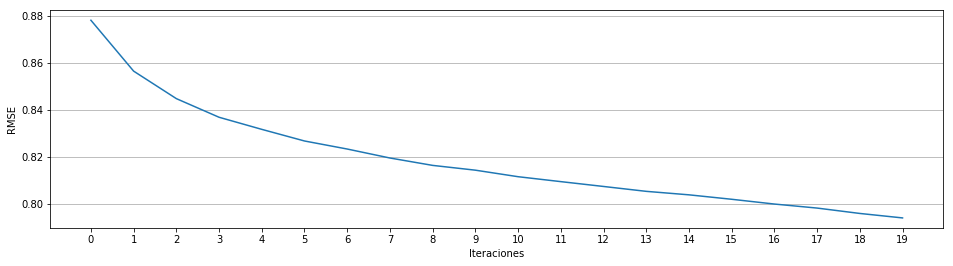

In [25]:
import matplotlib.pyplot as plt
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iteraciones")
plt.ylabel("RMSE")
plt.grid(axis="y")

### Comparaciones de Predicciones

In [32]:
CUR_df = pd.DataFrame
CUR_df = CUR
SVD90_df = pd.DataFrame
SVD90_df = SVD90

compara = pd.DataFrame(columns=['Usr', 'Película', 'Original', 'Pred CUR', 'Pred SVD_90', 'Pred SGD'])
compara = compara.append({'Usr': '0', 'Película': '0', 'Original': matriz_uspl[0][0], 'Pred CUR': CUR_df[0][0], 'Pred SVD_90': SVD90_df[0][0], 'Pred SGD': mf.full_matrix()[0][0]}, ignore_index=True)
compara = compara.append({'Usr': '5', 'Película': '2', 'Original': matriz_uspl[5][2], 'Pred CUR': CUR_df[5][2], 'Pred SVD_90': SVD90_df[5][2], 'Pred SGD': mf.full_matrix()[5][2]}, ignore_index=True)
compara = compara.append({'Usr': '7', 'Película': '4', 'Original': matriz_uspl[7][4], 'Pred CUR': CUR_df[7][4], 'Pred SVD_90': SVD90_df[7][4], 'Pred SGD': mf.full_matrix()[7][4]}, ignore_index=True)
compara = compara.append({'Usr': '313', 'Película': '3', 'Original': matriz_uspl[313][3], 'Pred CUR': CUR_df[313][3], 'Pred SVD_90': SVD90_df[313][3], 'Pred SGD': mf.full_matrix()[313][3]}, ignore_index=True)
compara = compara.append({'Usr': '316', 'Película': '16', 'Original': matriz_uspl[316][16], 'Pred CUR': CUR_df[316][16], 'Pred SVD_90': SVD90_df[316][16], 'Pred SGD': mf.full_matrix()[316][16]}, ignore_index=True)
compara = compara.append({'Usr': '609', 'Película': '3', 'Original': matriz_uspl[609][3], 'Pred CUR': CUR_df[609][3], 'Pred SVD_90': SVD90_df[609][3], 'Pred SGD': mf.full_matrix()[609][3]}, ignore_index=True)

In [33]:
print(compara)

   Usr Película  Original  Pred CUR  Pred SVD_90  Pred SGD
0    0        0       4.0       0.0     1.722981  4.599835
1    5        2       4.0       0.0    -0.170279  4.025648
2    7        4       5.0       5.0     0.784783  4.183601
3  313        3       1.0       0.0     3.280314  3.569334
4  316       16       5.0       0.0     4.093029  4.011689
5  609        3       5.0       5.0     1.682595  3.859338


#### Prueba con 20 factores
##### K = 20 factores
##### alpha (tasa de aprendizaje) = 0.01
##### beta (parámetro de regularización) = 0.1
##### iterations (iteraciones) = 20

In [36]:
t_1 = time() # Se cuenta el tiempo de procesamiento
mf_2 = MF(matriz_uspl, K=20, alpha=0.01, beta=0.1, iterations=20) # Se ingresa la matriz de 
# usuarios y películas
training_process_2 = mf_2.train() #Los valores de iteración y error se guardan en esta variable
t_2 = time()
print("Tiempo de procesamiento:",t_2 - t_1)

Iteration: 10 ; error = 0.8162
Iteration: 20 ; error = 0.7978
Tiempo de procesamiento: 277.1121208667755


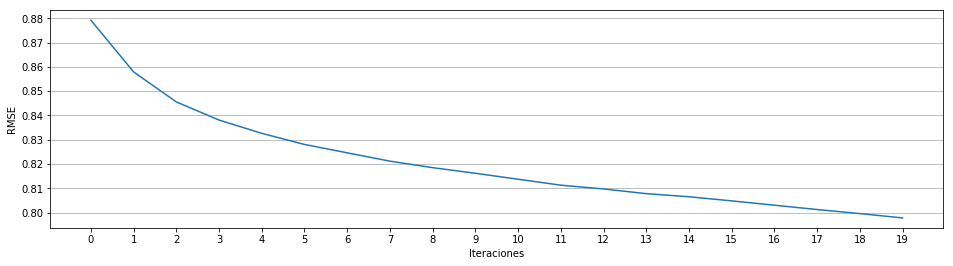

In [37]:
import matplotlib.pyplot as plt
x = [x for x, y in training_process_2]
y = [y for x, y in training_process_2]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iteraciones")
plt.ylabel("RMSE")
plt.grid(axis="y")

#### Prueba con 30 factores
##### K = 30 factores
##### alpha (tasa de aprendizaje) = 0.01
##### beta (parámetro de regularización) = 0.1
##### iterations (iteraciones) = 20

In [40]:
t_1 = time() # Se cuenta el tiempo de procesamiento
mf_3 = MF(matriz_uspl, K=30, alpha=0.01, beta=0.1, iterations=20) # Se ingresa la matriz de 
# usuarios y películas
training_process_3 = mf_3.train() #Los valores de iteración y error se guardan en esta variable
t_2 = time()
print("Tiempo de procesamiento:",t_2 - t_1)

Iteration: 10 ; error = 0.8164
Iteration: 20 ; error = 0.8001
Tiempo de procesamiento: 380.79756569862366


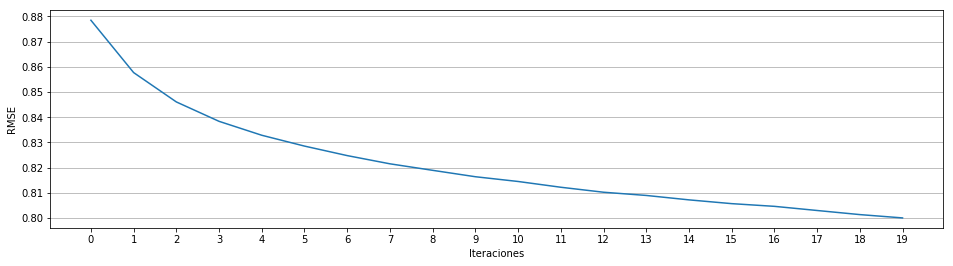

In [41]:
import matplotlib.pyplot as plt
x = [x for x, y in training_process_3]
y = [y for x, y in training_process_3]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iteraciones")
plt.ylabel("RMSE")
plt.grid(axis="y")

#### Prueba con 40 factores
##### K = 40 factores
##### alpha (tasa de aprendizaje) = 0.01
##### beta (parámetro de regularización) = 0.1
##### iterations (iteraciones) = 20

In [42]:
t_1 = time() # Se cuenta el tiempo de procesamiento
mf_4 = MF(matriz_uspl, K=40, alpha=0.01, beta=0.1, iterations=20) # Se ingresa la matriz de 
# usuarios y películas
training_process_4 = mf_4.train() #Los valores de iteración y error se guardan en esta variable
t_2 = time()
print("Tiempo de procesamiento:",t_2 - t_1)

Iteration: 10 ; error = 0.8171
Iteration: 20 ; error = 0.8007
Tiempo de procesamiento: 521.5442752838135


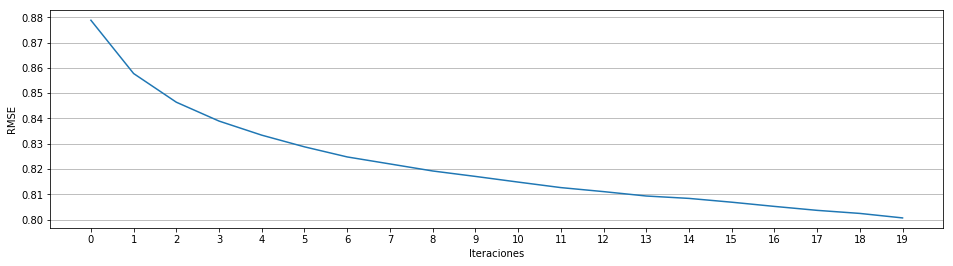

In [43]:
import matplotlib.pyplot as plt
x = [x for x, y in training_process_4]
y = [y for x, y in training_process_4]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iteraciones")
plt.ylabel("RMSE")
plt.grid(axis="y")

#### Prueba con 20 factores, 40 iteraciones
##### K = 20 factores
##### alpha (tasa de aprendizaje) = 0.01
##### beta (parámetro de regularización) = 0.1
##### iterations (iteraciones) = 40

In [44]:
t_1 = time() # Se cuenta el tiempo de procesamiento
mf_5 = MF(matriz_uspl, K=20, alpha=0.01, beta=0.1, iterations=40) # Se ingresa la matriz de usuarios y películas
training_process_5 = mf_5.train() # Los valores de iteración y error se guardan en esta variable
t_2 = time()
print("Tiempo de procesamiento:",t_2 - t_1)

Iteration: 10 ; error = 0.8157
Iteration: 20 ; error = 0.7973
Iteration: 30 ; error = 0.7726
Iteration: 40 ; error = 0.7400
Tiempo de procesamiento: 603.7711415290833


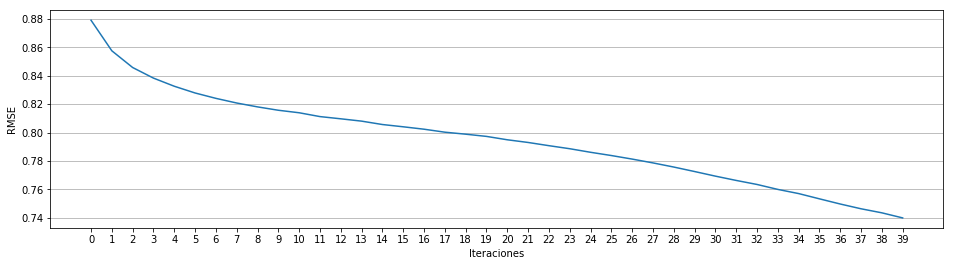

In [45]:
import matplotlib.pyplot as plt
x = [x for x, y in training_process_5]
y = [y for x, y in training_process_5]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iteraciones")
plt.ylabel("RMSE")
plt.grid(axis="y")

#### Prueba con 20 factores, 100 iteraciones
##### K = 20 factores
##### alpha (tasa de aprendizaje) = 0.01
##### beta (parámetro de regularización) = 0.1
##### iterations (iteraciones) = 100

In [46]:
t_1 = time() # Se cuenta el tiempo de procesamiento
mf_5 = MF(matriz_uspl, K=20, alpha=0.01, beta=0.1, iterations=100) # Se ingresa la matriz de usuarios y películas
training_process_5 = mf_5.train() # Los valores de iteración y error se guardan en esta variable
t_2 = time()
print("Tiempo de procesamiento:",t_2 - t_1)

Iteration: 10 ; error = 0.8160
Iteration: 20 ; error = 0.7978
Iteration: 30 ; error = 0.7757
Iteration: 40 ; error = 0.7416
Iteration: 50 ; error = 0.7049
Iteration: 60 ; error = 0.6727
Iteration: 70 ; error = 0.6475
Iteration: 80 ; error = 0.6272
Iteration: 90 ; error = 0.6120
Iteration: 100 ; error = 0.5999
Tiempo de procesamiento: 1306.313010931015


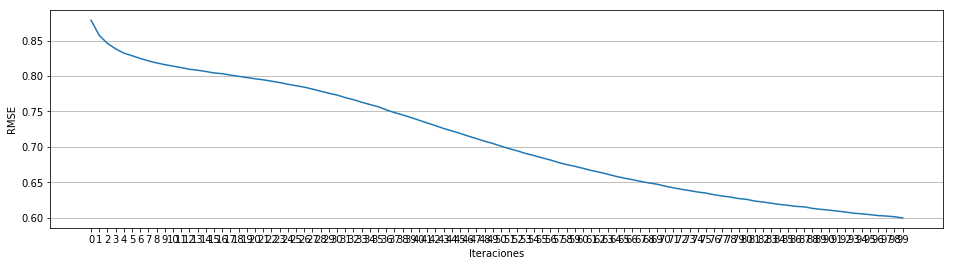

In [47]:
import matplotlib.pyplot as plt
x = [x for x, y in training_process_5]
y = [y for x, y in training_process_5]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iteraciones")
plt.ylabel("RMSE")
plt.grid(axis="y")

### Comparaciones de Predicciones SGD

In [50]:
compara_2 = pd.DataFrame(columns=['Usr', 'Película', 'Original', 'SGD_K10_I20', 'SGD_K20_I100'])
compara_2 = compara_2.append({'Usr': '0', 'Película': '0', 'Original': matriz_uspl[0][0], 'SGD_K10_I20': mf.full_matrix()[0][0], 'SGD_K20_I100': mf_5.full_matrix()[0][0]},ignore_index=True)
compara_2 = compara_2.append({'Usr': '5', 'Película': '2', 'Original': matriz_uspl[5][2], 'SGD_K10_I20': mf.full_matrix()[5][2], 'SGD_K20_I100': mf_5.full_matrix()[5][2]},ignore_index=True)
compara_2 = compara_2.append({'Usr': '7', 'Película': '4', 'Original': matriz_uspl[7][4], 'SGD_K10_I20': mf.full_matrix()[7][4], 'SGD_K20_I100': mf_5.full_matrix()[7][4]},ignore_index=True)
compara_2 = compara_2.append({'Usr': '313', 'Película': '3', 'Original': matriz_uspl[313][3], 'SGD_K10_I20': mf.full_matrix()[313][3],'SGD_K20_I100': mf_5.full_matrix()[313][3]}, ignore_index=True)
compara_2 = compara_2.append({'Usr': '316', 'Película': '16', 'Original': matriz_uspl[316][16], 'SGD_K10_I20': mf.full_matrix()[316][16], 'SGD_K20_I100': mf_5.full_matrix()[316][16]},ignore_index=True)
compara_2 = compara_2.append({'Usr': '609', 'Película': '3', 'Original': matriz_uspl[609][3], 'SGD_K10_I20': mf.full_matrix()[609][3], 'SGD_K20_I100': mf_5.full_matrix()[609][3]},ignore_index=True)

In [51]:
print(compara_2)

   Usr Película  Original  SGD_K10_I20  SGD_K20_I100
0    0        0       4.0     4.599835      4.476277
1    5        2       4.0     4.025648      3.949980
2    7        4       5.0     4.183601      4.281579
3  313        3       1.0     3.569334      3.353286
4  316       16       5.0     4.011689      4.649035
5  609        3       5.0     3.859338      4.188230
